Тестовое задание   
выполнила Могиленко Ольга

## Анализ цен на золото и газ
1. Задание выполнять в jupyter notebook
2. [Скачать финансовые данные запросом (инструкция ниже) ](#section_2)    
a. Цена на газ в европе в eur (ticker TTF=F)  
b. Цена на золото в usd (ticker GC=F)  
c. Конвертация usd в eur (ticker USDEUR=X)    
3. [Преобразовать все датасеты в данные по месяцам (применить average если
данные более подробные)](#section_3)   
4. [Нарисовать графики ](#section_4)   
a. Прирост цены с предыдущего месяца  
b. Относительный рост по месяцам для золота и газа на одном графике (в
пересчете на евро по курсу)  
5. [Загрузить данные из п1 в sqlite базу данных  ](#section_5)  
a. Написать sql запросы для расчета пунктов 4а и 4б на sql

In [1]:
# pip install pandas-datareader
# pip install requests

In [2]:
import pandas as pd
import pandas_datareader as pdr
import datetime 
from datetime import datetime, timedelta
import requests  
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

Для сравнительного анализа показателей определим с какого периода есть данные о котировках для эмитентов TTF и GC и оставим только данные за совпадающий период.   


In [3]:
url = 'https://query2.finance.yahoo.com/v8/finance/chart/TTF=F?period1=0&period2=9999999999&interval=1d'  
headers = {'User-Agent': 'Mozilla/5.0'}
data1 = requests.get(url, headers=headers).json()['chart']['result'][0]['timestamp'][0]
# print(data1) 

In [4]:
url = 'https://query2.finance.yahoo.com/v8/finance/chart/GC=F?period1=0&period2=9999999999&interval=1d'  
data2 = requests.get(url, headers=headers).json()['chart']['result'][0]['timestamp'][0]
# print(data2)

In [5]:
if data1>=data2:
    mindata=data1
else: mindata=data2    

In [6]:
mindata=datetime.utcfromtimestamp(mindata).strftime('%Y-%m-%d')
mindata

'2017-10-23'

Исследуемый период с 23 октября 2017 года по текущую дату. 

<a id='section_2'></a>
**2.Получение финансовых данных**  

Так как у Yahoo нет официального API, поэтому для обращения к yahoo.finance и получения необходимых данных удобнее воспользоваться **pandas_datareader** и с помощью функции **get_data_yahoo** вывести готовые датафреймы **ttf, gc, usdeur**

In [7]:
ttf = pdr.get_data_yahoo('TTF=F', 
                          start=datetime.strptime(mindata, '%Y-%m-%d'), 
                          end=datetime.now())

выберем для анализа показатель **Adj Close** - скорректированную цену закрытия торговой сессии и переименуем столбец

In [8]:
ttf=ttf.rename(columns={'Adj Close':'TTF_eur'})
ttf.head()

,High,Low,Open,Close,Volume,TTF_eur
Date,,,,,,
2017-10-23,18.090000,18.090000,18.090000,18.090000,0.0,18.090000
2017-10-24,17.959999,17.959999,17.959999,17.959999,0.0,17.959999
2017-10-25,18.110001,18.110001,18.110001,18.110001,0.0,18.110001
2017-10-26,18.070000,18.070000,18.070000,18.070000,0.0,18.070000
2017-10-27,18.150000,18.150000,18.150000,18.150000,0.0,18.150000


проделаем то же самое для **GC** и **USDEUR**

In [9]:
gc = pdr.get_data_yahoo('GC=F', 
                          start=datetime.strptime(mindata, '%Y-%m-%d'), 
                          end=datetime.now())
gc=gc.rename(columns={'Adj Close':'GC'})
gc.head()

,High,Low,Open,Close,Volume,GC
Date,,,,,,
2017-10-23,1280.800049,1271.500000,1274.699951,1277.699951,115.0,1277.699951
2017-10-24,1275.500000,1273.699951,1275.500000,1275.000000,111.0,1275.000000
2017-10-25,1275.400024,1269.900024,1269.900024,1275.400024,105.0,1275.400024
2017-10-26,1273.500000,1264.699951,1273.500000,1266.300049,39.0,1266.300049
2017-10-27,1268.500000,1267.099976,1268.400024,1268.500000,567.0,1268.500000


In [10]:
gc.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1003 entries, 2017-10-23 to 2021-10-29
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   High    1003 non-null   float64
 1   Low     1003 non-null   float64
 2   Open    1003 non-null   float64
 3   Close   1003 non-null   float64
 4   Volume  1003 non-null   float64
 5   GC      1003 non-null   float64
dtypes: float64(6)
memory usage: 54.9 KB


In [11]:
usdeur = pdr.get_data_yahoo('USDEUR=X', 
                          start=datetime.strptime(mindata, '%Y-%m-%d'), 
                          end=datetime.now())
usdeur=usdeur.rename(columns={'Adj Close':'usdeur'})                
usdeur.head()


,High,Low,Open,Close,Volume,usdeur
Date,,,,,,
2017-10-22,0.85222,0.848969,0.85072,0.85080,0.0,0.85080
2017-10-23,0.85151,0.849100,0.85068,0.85040,0.0,0.85040
2017-10-24,0.85079,0.846200,0.85035,0.85041,0.0,0.85041
2017-10-25,0.85527,0.844910,0.84587,0.84597,0.0,0.84597
2017-10-26,0.86386,0.858800,0.85918,0.85931,0.0,0.85931


In [12]:
df=gc.merge(usdeur, how='left',left_index=True, right_index=True)[['GC', 'usdeur']]
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1003 entries, 2017-10-23 to 2021-10-29
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   GC      1003 non-null   float64
 1   usdeur  883 non-null    float64
dtypes: float64(2)
memory usage: 55.8 KB


оказалось, что за несколько дней нет данных о курсе евро к доллару, заменим пропущенные значения медианным значением кросскурса

In [13]:
df.usdeur.fillna(df.usdeur.median(), inplace=True)
df

,GC,usdeur
Date,,
2017-10-23,1277.699951,0.85040
2017-10-24,1275.000000,0.85041
2017-10-25,1275.400024,0.84597
2017-10-26,1266.300049,0.85931
2017-10-27,1268.500000,0.86120
...,...,...
2021-10-25,1806.000000,0.86120
2021-10-26,1792.699951,0.86220
2021-10-27,1797.900024,0.86206


переведём значения котировок золота в евро

In [14]:
df['GC_eur']=df['GC']*df['usdeur']
df

,GC,usdeur,GC_eur
Date,,,
2017-10-23,1277.699951,0.85040,1086.556001
2017-10-24,1275.000000,0.85041,1084.272730
2017-10-25,1275.400024,0.84597,1078.950127
2017-10-26,1266.300049,0.85931,1088.144259
2017-10-27,1268.500000,0.86120,1092.432168
...,...,...,...
2021-10-25,1806.000000,0.86120,1555.327155
2021-10-26,1792.699951,0.86220,1545.665937
2021-10-27,1797.900024,0.86206,1549.897714


объединим датафремы с котировками и оставим только нужные столбцы

In [15]:
df=df.merge(ttf, left_index=True, right_index=True)
df.head()

,GC,usdeur,GC_eur,High,Low,Open,Close,Volume,TTF_eur
Date,,,,,,,,,
2017-10-23,1277.699951,0.85040,1086.556001,18.090000,18.090000,18.090000,18.090000,0.0,18.090000
2017-10-24,1275.000000,0.85041,1084.272730,17.959999,17.959999,17.959999,17.959999,0.0,17.959999
2017-10-25,1275.400024,0.84597,1078.950127,18.110001,18.110001,18.110001,18.110001,0.0,18.110001
2017-10-26,1266.300049,0.85931,1088.144259,18.070000,18.070000,18.070000,18.070000,0.0,18.070000
2017-10-27,1268.500000,0.86120,1092.432168,18.150000,18.150000,18.150000,18.150000,0.0,18.150000


In [16]:
df=df[['GC_eur','TTF_eur']]
df

,GC_eur,TTF_eur
Date,,
2017-10-23,1086.556001,18.090000
2017-10-24,1084.272730,17.959999
2017-10-25,1078.950127,18.110001
2017-10-26,1088.144259,18.070000
2017-10-27,1092.432168,18.150000
...,...,...
2021-10-22,1546.284555,87.337997
2021-10-25,1555.327155,88.642998
2021-10-26,1545.665937,88.492996


<a id='section_3'></a>
**3. преобразуем датафрейм таким образом, чтобы отслеживать изменения по месяцам**


In [17]:
monthly_df=df.resample('M').mean()
monthly_df=monthly_df.rename(index=lambda x: x.strftime('%Y-%m'))
# уменьшим разрядность выводимых данных для более легкого восприятия
pd.options.display.float_format = '{:,.4f}'.format

посчитаем изменение котировок газа и золота по месяцам и относительное изменение этих параметров

In [18]:
monthly_df['GC_prev_month']=monthly_df['GC_eur'].shift(1, fill_value=0)
monthly_df['TTF_prev_month']=monthly_df['TTF_eur'].shift(1, fill_value=0)
monthly_df['GC_diff']=monthly_df['GC_eur']-monthly_df['GC_prev_month']
monthly_df['TTF_diff']=monthly_df['TTF_eur']-monthly_df['TTF_prev_month']
monthly_df['GC_diff_%']=monthly_df['GC_diff']/monthly_df['GC_eur']*100
monthly_df['TTF_diff_%']=monthly_df['TTF_diff']/monthly_df['TTF_eur']*100
monthly_df.tail()

,GC_eur,TTF_eur,GC_prev_month,TTF_prev_month,GC_diff,TTF_diff,GC_diff_%,TTF_diff_%
Date,,,,,,,,
2021-06,"1,532.5973",29.1683,"1,538.3725",25.0180,-5.7751,4.1503,-0.3768,14.2287
2021-07,"1,534.0806",36.0195,"1,532.5973",29.1683,1.4833,6.8513,0.0967,19.0209
2021-08,"1,520.4763",44.7136,"1,534.0806",36.0195,-13.6043,8.6941,-0.8947,19.4439
2021-09,"1,514.1780",66.8390,"1,520.4763",44.7136,-6.2983,22.1255,-0.4160,33.1026
2021-10,"1,531.0726",92.6566,"1,514.1780",66.8390,16.8946,25.8176,1.1035,27.8637


In [19]:
# заменим на 0 значения изменений в первый месяц наблюдения
monthly_df.iloc[0,4:]=0
monthly_df.head()

,GC_eur,TTF_eur,GC_prev_month,TTF_prev_month,GC_diff,TTF_diff,GC_diff_%,TTF_diff_%
Date,,,,,,,,
2017-10,"1,087.9410",18.1107,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
2017-11,"1,093.1685",19.4775,"1,087.9410",18.1107,5.2276,1.3668,0.4782,7.0173
2017-12,"1,069.6991",20.5508,"1,093.1685",19.4775,-23.4694,1.0733,-2.1940,5.2224
2018-01,"1,093.2598",18.6480,"1,069.6991",20.5508,23.5607,-1.9027,2.1551,-10.2035
2018-02,"1,076.6979",18.4734,"1,093.2598",18.6480,-16.5619,-0.1746,-1.5382,-0.9450


**4. Построим графики изменения котировок**
<a id='section_4'></a>

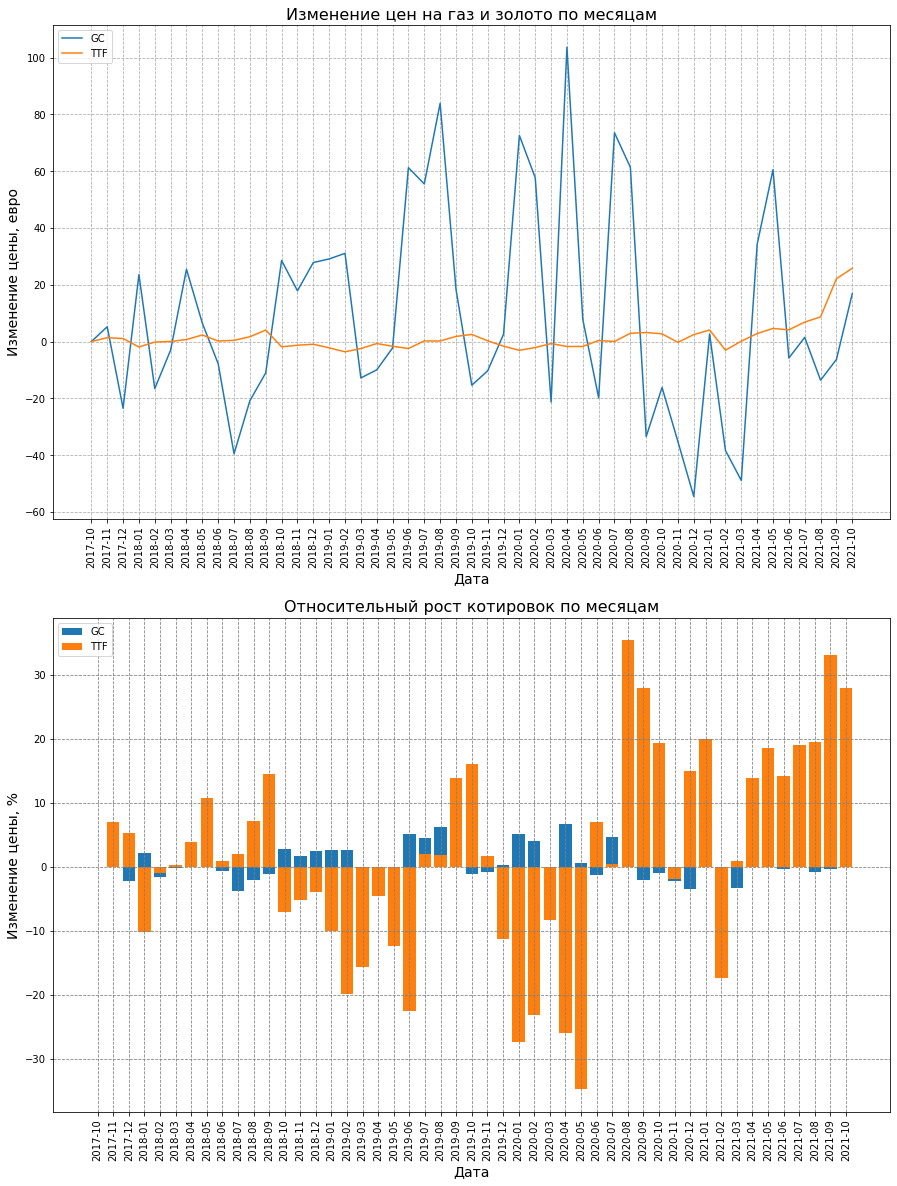

In [20]:
fig,ax=plt.subplots(2,1,figsize=(15, 20))
plt.grid(True, color='grey',linestyle='--', linewidth=0.8)
plt.xticks(rotation=90)

gc1=monthly_df['GC_diff']
ttf1=monthly_df['TTF_diff']
gc2=monthly_df['GC_diff_%']
ttf2=monthly_df['TTF_diff_%']

ax[0].plot(gc1, label='GC')
ax[0].plot(ttf1, label='TTF')
ax[1].bar(x=monthly_df.index, height=gc2, label='GC')
ax[1].bar(x=monthly_df.index,height=ttf2, label='TTF')

ax[0].xaxis.grid(True, which='major',linestyle='--', linewidth=0.8)
ax[0].yaxis.grid(True, which='major',linestyle='--', linewidth=0.8)
ax[0].set_xticklabels( monthly_df.index, rotation='90' )
ax[0].set_title('Изменение цен на газ и золото по месяцам', size=16)
ax[0].set_xlabel('Дата', size=14)
ax[0].set_ylabel('Изменение цены, евро', size=14)
ax[0].legend(loc=2)
ax[1].set_title('Относительный рост котировок по месяцам', size=16)
ax[1].set_xlabel('Дата', size=14)
ax[1].set_ylabel('Изменение цены, %', size=14)
ax[1].legend(loc=2)

plt.show()

In [21]:
monthly_df[['GC_diff_%','TTF_diff_%']].agg(['max','min'])

,GC_diff_%,TTF_diff_%
max,6.7112,35.4102
min,-3.7327,-34.8350


Можно сделать вывод, что **TTF** более волатильный по сравнению с **GC**

**5. Теперь проделаем те же операции с данными в sqlite**
<a id='section_5'></a>

In [22]:
import sqlite3 as sl

In [23]:
con = sl.connect('ubirator-test.db')

In [24]:
with con:
    con.execute('''
    DROP TABLE IF EXISTS ttf_sql;
    ''')

In [25]:
ttf.to_sql('ttf_sql', con)

In [26]:
with con:
    data = con.execute("SELECT Date, TTF_eur FROM ttf_sql LIMIT 3")
    for row in data:
        print(row)

('2017-10-23 00:00:00', 18.09000015258789)
('2017-10-24 00:00:00', 17.959999084472656)
('2017-10-25 00:00:00', 18.110000610351562)


In [27]:
with con:
    con.execute('''
    DROP TABLE IF EXISTS gc_sql
    ''')

In [28]:
gc.to_sql('gc_sql', con)

In [29]:
with con:
    data = con.execute("SELECT Date, GC FROM gc_sql LIMIT 3")
    for row in data:
        print(row)

('2017-10-23 00:00:00', 1277.699951171875)
('2017-10-24 00:00:00', 1275.0)
('2017-10-25 00:00:00', 1275.4000244140625)


In [30]:
with con:
    con.execute('''
    DROP TABLE IF EXISTS usdeur_sql
    ''')

In [31]:
usdeur.to_sql('usdeur_sql', con)

In [32]:
with con:
    data = con.execute("SELECT Date, usdeur FROM usdeur_sql LIMIT 3")
    for row in data:
        print(row)

('2017-10-22 00:00:00', 0.8507999777793884)
('2017-10-23 00:00:00', 0.8503999710083008)
('2017-10-24 00:00:00', 0.850409984588623)


In [33]:
with con:
    dt = con.execute(
        '''WITH gc_ue as\
                 (SELECT gc.Date as Date, gc.GC as GC, ue.usdeur as usdeur\
                  FROM gc_sql as gc LEFT JOIN usdeur_sql as ue ON gc.Date=ue.Date),\
                  \
                df_gc as\
                 (SELECT gc_ue.Date as Date, gc_ue.GC as GC,\
                  CASE WHEN gc_ue.usdeur is null \
                      THEN (SELECT round(ue.usdeur,4) \
                           FROM usdeur_sql as ue \
                           ORDER BY ue.usdeur \
                           LIMIT 1 \
                           OFFSET (SELECT count(*) FROM usdeur_sql)/2)\
                      ELSE gc_ue.usdeur end as usdeur\
                   FROM gc_ue),\
                    \
                 df1 as \
                 (SELECT df_gc.Date, df_gc.GC*df_gc.usdeur as GC_eur FROM df_gc)
                    \
                 SELECT strftime('%Y-%m', df1.Date), round(avg(df1.GC_eur),3), round(avg(ttf.TTF_eur),3) \
                 FROM df1 join ttf_sql as ttf on df1.Date=ttf.Date group by 1''')
    for row in dt:
        print(row)

('2017-10', 1087.905, 18.111)
('2017-11', 1093.156, 19.478)
('2017-12', 1069.699, 20.551)
('2018-01', 1093.26, 18.648)
('2018-02', 1076.698, 18.473)
('2018-03', 1073.712, 18.51)
('2018-04', 1099.123, 19.24)
('2018-05', 1105.592, 21.562)
('2018-06', 1097.781, 21.748)
('2018-07', 1058.288, 22.192)
('2018-08', 1037.465, 23.893)
('2018-09', 1026.469, 27.951)
('2018-10', 1055.037, 26.113)
('2018-11', 1072.963, 24.827)
('2018-12', 1100.786, 23.886)
('2019-01', 1129.889, 21.693)
('2019-02', 1160.949, 18.085)
('2019-03', 1148.161, 15.628)
('2019-04', 1138.158, 14.94)
('2019-05', 1135.865, 13.292)
('2019-06', 1197.111, 10.842)
('2019-07', 1252.632, 11.067)
('2019-08', 1336.483, 11.275)
('2019-09', 1354.942, 13.095)
('2019-10', 1339.574, 15.612)
('2019-11', 1329.345, 15.887)
('2019-12', 1331.912, 14.267)
('2020-01', 1404.493, 11.193)
('2020-02', 1462.207, 9.084)
('2020-03', 1440.931, 8.385)
('2020-04', 1544.544, 6.657)
('2020-05', 1552.317, 4.937)
('2020-06', 1532.544, 5.312)
('2020-07', 1606.06